# Ensemble methods (adaBoost, random forests) 

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 
%matplotlib inline 

Run the helper code below to create a training and validation set of threes and eights from the MNIST dataset. There is also a helper function to display digits. 

In [3]:
class ThreesandEights:
    """
    Class to store MNIST 3s and 8s data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        x_train, y_train, x_test, y_test = pickle.load(f)
                
        # Extract only 3's and 8's for training set 
        self.x_train = x_train[np.logical_or(y_train== 3, y_train == 8), :]
        self.y_train = y_train[np.logical_or(y_train== 3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.x_train.shape[0])
        np.random.shuffle(shuff)
        self.x_train = self.x_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.x_test = x_test[np.logical_or(y_test== 3, y_test == 8), :]
        self.y_test = y_test[np.logical_or(y_test== 3, y_test == 8)]
        self.y_test = np.array([1 if y == 8 else -1 for y in self.y_test])
        
        f.close()

def view_digit(ex, label=None, feature=None):
    """
    function to plot digit examples 
    """
    if label: print("true label: {:d}".format(label))
    img = ex.reshape(21,21)
    col = np.dstack((img, img, img))
    if feature is not None: col[feature[0]//21, feature[0]%21, :] = [1, 0, 0]
    plt.imshow(col)
    plt.xticks([]), plt.yticks([])
    
data = ThreesandEights("data/mnist21x21_3789.pklz")

true label: -1


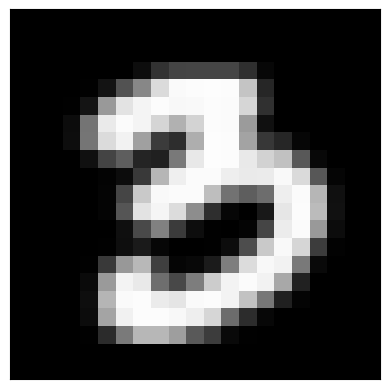

In [4]:
view_digit(data.x_train[0], data.y_train[0])

### Building an Adaboost Classifier to classify MNIST digits 3 and 8.

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient. 

In the `AdaBoost` class below, implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

Recall that the AdaBoost algorithm is as follows: 

`for k=1 to K:`

$~~~~~~~$ `    a) Fit kth weak learner to training data with weights w`

$~~~~~~~$ `    b) Computed weighted error errk for the kth weak learner (Check Adaboost slides for formula).`

$~~~~~~~$ `    c) compute vote weight alpha[k] = 0.5 ln ((1-errk)/errk))`

$~~~~~~~$ `    d) update training example weights w[i] *= exp[-alpha[k] y[i] h[k](x[i])]`

$~~~~~~~$ `    e) normalize training weights so they sum to 1`
<br><br>

In [20]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=3), random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(42)
        
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """

        # =================================================================
        # TODO 

        # Note: You can create and train a new instantiation 
        # of your sklearn decision tree as follows 
        # you don't have to use sklearn's fit function, 
        # but it is probably the easiest way 

        # w = np.ones(len(y_train))
        # w /= np.sum(w) 
        # for loop
        #   h = clone(self.base)
        #   h.fit(X_train, y_train, sample_weight=w)
        #   ...
        #
        #
        #   ...
        #   Save alpha and learner
        
        # =================================================================
        
        # your code here
        w = np.ones(len(y_train))
        w /= np.sum(w)
        for i in range(self.n_learners):
            h = clone(self.base)
            h.fit(X_train,y_train,w)

            yh = h.predict(X_train)
            
            e_b = self.error_rate(y_train,yh,w)

            coef_b = 1/2 * np.log((1-e_b)/e_b)
            
            w = w * np.exp(-coef_b*y_train*yh)
            #w /= np.sum(w)
        
            self.alpha[i] = coef_b
            self.learners.append(h)
        
        return self  
            
    def error_rate(self, y_true, y_pred, weights):
        # =================================================================
        # TODO 

        # Implement the weighted error rate
        # =================================================================
        # your code here
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        not_equal_index = np.where(y_true != y_pred)
        
        return np.sum(weights[not_equal_index])/np.sum(weights)
        
        
    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """

        # =================================================================
        # TODO
        # =================================================================
        yhat = np.zeros(X.shape[0])
        
        # your code here
        for alpha, hypothesis in zip(self.alpha, self.learners):
            yhat += alpha*hypothesis.predict(X)
        return np.sign(yhat)
    
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """
        
        # your code here
        yh = self.predict(X)
        true_predicted = [1 if yp == yr else 0 for yp, yr in zip(yh,y)]
        return sum(true_predicted)/len(y)
        
        
    
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """

        scores = []
        
        n = len(y)
        yhat = np.zeros(X.shape[0])
        # your code here
        for alpha, hypothesis in zip(self.alpha, self.learners):
            yhat += alpha*hypothesis.predict(X)
            true_predicted = [1 if yp == yr else 0 for yp, yr in zip(np.sign(yhat),y)]
            scores.append(sum(true_predicted)/n)
        
        return np.array(scores)        



In [6]:
# Sample test for Adaboost error rate function. 
import pytest

y_true = [-1, 1, 1, -1, 1, -1, -1]
y_pred = [-1, 1, 1, 1, 1, -1, 1]
w = np.ones(len(y_true))
w /= np.sum(w)

clf = AdaBoost() 
err_rate = clf.error_rate(y_true, y_pred, w)
assert pytest.approx(err_rate, 0.01) == 0.2857, "Check the error_rate function."

In [7]:
# Sample test for Adaboost fit function. 

sample_data = np.load('data/train.npz') 
sample_X = sample_data['X']
sample_y = sample_data['y']
test_model = AdaBoost(n_learners=5).fit(sample_X,sample_y)
t_alpha = [1.94591015, 2.14179328, 2.48490665, 1.94679667, 2.22627839]
assert pytest.approx(test_model.alpha, 0.01) == t_alpha, "Check the fit function"

Use the fit function to fit the Adaboost classifier with 150 base decision tree stumps

In [21]:
print(len(data.y_train))
clf = AdaBoost(n_learners=150, base = DecisionTreeClassifier(max_depth=1)).fit(data.x_train,data.y_train)

2000


After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples. You can test out the predictions in the cell below.   **Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

Just print out your predictions on the training set in the cell below.

In [22]:
train_predict = clf.predict(data.x_train)
print(len(data.y_train))
print(train_predict)

2000
[-1.  1.  1. ... -1. -1.  1.]


Once your `predict` function is written up, you need to test the scores on the function. To do this compute the scores on the prediction in the `score` function. Use the `score` function to then complete `staged_score` to collect the scores for every boosting iterations. Plot the misclassification error for train and test sets (misclassification error = 1- score)

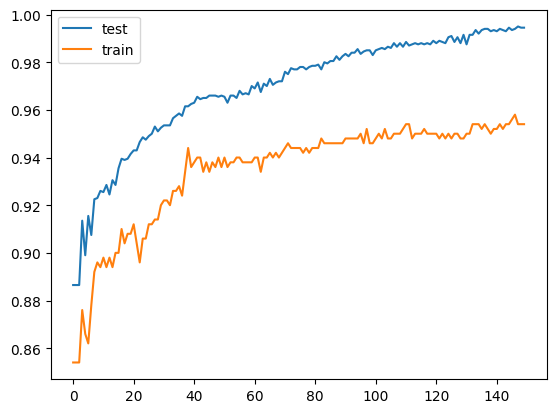

In [31]:
import os 
if not os.path.exists("staged_scores.png"):
    train_staged_scores = clf.staged_score(data.x_train,data.y_train)
    test_staged_scores = clf.staged_score(data.x_test,data.y_test)
    plt.plot(train_staged_scores)
    plt.plot(test_staged_scores)
    plt.legend(["test","train"])
    plt.savefig("staged_scores.png")